In [46]:
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ndjson
import json
import time
import pandas_gbq

In [47]:
X,y = make_classification(n_samples=1500000,
                          n_features=10,
                          n_informative=10,
                          n_redundant=0,
                          n_repeated=0,
                          n_classes=2, weights=[0.95,0.05],flip_y=0, random_state=32)

In [48]:
X = pd.DataFrame(X, columns=['inventory', 
                             'lead_time', 
                             'forecast_3_mon', 
                             'forecast_6_mon',
                             'sales_1_mon', 
                             'sales_3_mon', 
                             'sales_6_mon',
                             'potential_issue',
                             'pieces_past_due',
                             'min_rec_stock'
                            ])

In [49]:
X.head()

,inventory,lead_time,forecast_3_mon,forecast_6_mon,sales_1_mon,sales_3_mon,sales_6_mon,potential_issue,pieces_past_due,min_rec_stock
0,-1.121051,2.852774,-3.446964,-2.849742,-0.452482,-2.438892,0.683574,-1.119757,-2.902390,-2.165217
1,1.648915,2.577414,0.709671,1.093720,1.274580,0.405842,1.342777,2.162144,0.133709,0.495183
2,-1.881091,-1.864079,-1.677800,-2.286465,3.170775,-1.097698,-3.423392,1.102386,-3.136253,-0.449521
3,-0.860851,0.084452,-1.336023,-1.607596,-2.766790,-2.952167,-3.215127,3.111840,-0.174635,4.433006
4,3.122227,1.628874,-2.281742,-1.838121,0.444281,1.167371,4.271829,-0.252804,-0.926022,1.931466


In [17]:
inven_labels = [i for i in range(0,31)]
X['inventory'] = pd.cut(X['inventory'],31, labels=inven_labels)
X['inventory'] = X['inventory'].astype(int)

In [18]:
lead_labels = [i for i in range(1,21)]
X['lead_time'] = pd.cut(X['lead_time'], 20, labels=lead_labels)
X['lead_time'] = X['lead_time'].astype(int)

In [19]:
X['lead_time'] = [np.random.randint(10,20) for i in X['lead_time']]

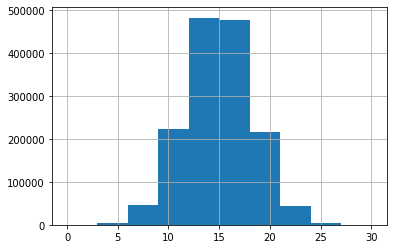

In [20]:
X['inventory'].hist()

In [21]:
X['forecast_3_mon'] =  X['forecast_3_mon'].apply(lambda x: np.round(x+ np.random.randint(10,50),0))

In [22]:
X['forecast_6_mon'] = [i*np.random.randint(1,3) for i in X['forecast_3_mon']]

In [23]:
X['sales_1_mon'] = [np.round(i+np.random.randint(10,20),0) for i in X['sales_1_mon']]

X['sales_3_mon'] = [i*np.random.randint(1,3) for i in X['sales_1_mon']]

#Sales 6 months
X['sales_6_mon'] = [i*np.random.randint(1,5) for i in X['sales_3_mon']]


In [26]:
X['potential_issue'] = (X['sales_1_mon'] > X['inventory']) & (X['lead_time'] < 30)

In [29]:
X['potential_issue'] = X['potential_issue'].replace({True:1, False:0})

In [32]:
#Pieces past due
X['pieces_past_due'] = np.round([i*-1 if i < 0 else i for i in X['pieces_past_due']],0)

In [33]:
min_stock=[]
for i,j in zip(X['min_rec_stock'], X['sales_1_mon']):
        if (i < 0) & (j > 10):
            min_stock.append((i*-1)*5)
        elif (i < 0) & (j < 10):
            min_stock.append((i*-1)+5)
        elif (i > 0) & (j > 10):
            min_stock.append(i*5)
        else:
            min_stock.append(i+5)
X['min_rec_stock'] = np.round(min_stock,0)

In [34]:
X['backorder'] = y

#Add sku id
X['sku'] = range(1,len(X['backorder']) + 1)

In [45]:
#Convert to dicts and save as json

"""
In this section, 5 tables will be created
    1. Inventory - will include sku, inventory, pieces past due, and min rec stock
    2. Sales - will include sku, sales 1 mon, sales 3 mon, and sales 6 mon
    3. Forecasts - will include sku, forecast 3 month, forecast 6 month
    4. Inventory ordering - will include sku, lead time, and potential issue
    5. Backorder - will include sku and if the item went on backorder
"""   
start = time.time()
inventory = np.asanyarray(X[['sku', 'inventory', 'pieces_past_due', 'min_rec_stock']])
inventory_list=[]
for i in range(0,len(inventory)):
    subset = inventory[i]
    record = {'sku' : int(subset[0]),
             'inventory': int(subset[1]),
             'pieces_past_due': int(subset[2]),
             'min_rec_stock': int(subset[3])}
    inventory_list.append(record)
    
assert X['sku'][0] == inventory_list[0]['sku']
assert len(inventory_list) == len(X['sku'])
with open('inventory.ndjson', 'w') as f:
    ndjson.dump(inventory_list,f)
    
print('Sales json saved')
end = time.time()
print("Total time was " + str(np.round((end-start)/60,2)) + " minutes")

Sales json saved
Total time was 0.14 minutes
